In [1]:
from datetime import date, timedelta
import geopandas, pandas as pd
from constants import *
from download import download
from geo import convert_df
from phe import plot_areas, recent_phe_data_summed, map_data as phe_map_data, plot_map as phe_plot_map
from zoe import latest_map_data as zoe_map_data, bokeh_plot_map as zoe_plot_map, add_simple_geoms
from plotting import matplotlib_zoe_vs_phe_map, geoplot_bokeh, save_to_disk, bokeh_zoe_vs_phe_map
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
force_download = False
for_date = date.today()-timedelta(days=1)

In [20]:
# download cases data
suffix = 'csv'
for type_ in 'cases', 'deaths':
    path = base_path / f'coronavirus-cases_{for_date}.{suffix}'
    if force_download or not path.exists():
        download(cases_url.format(data_type=suffix), path)

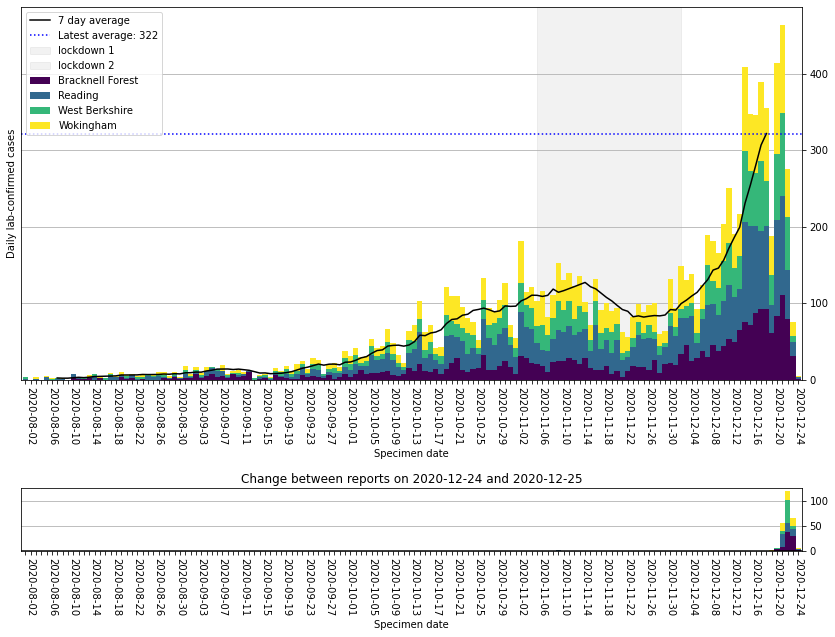

In [21]:
plot_areas(for_date, areas=my_areas, uncertain_days=5, earliest=second_wave)

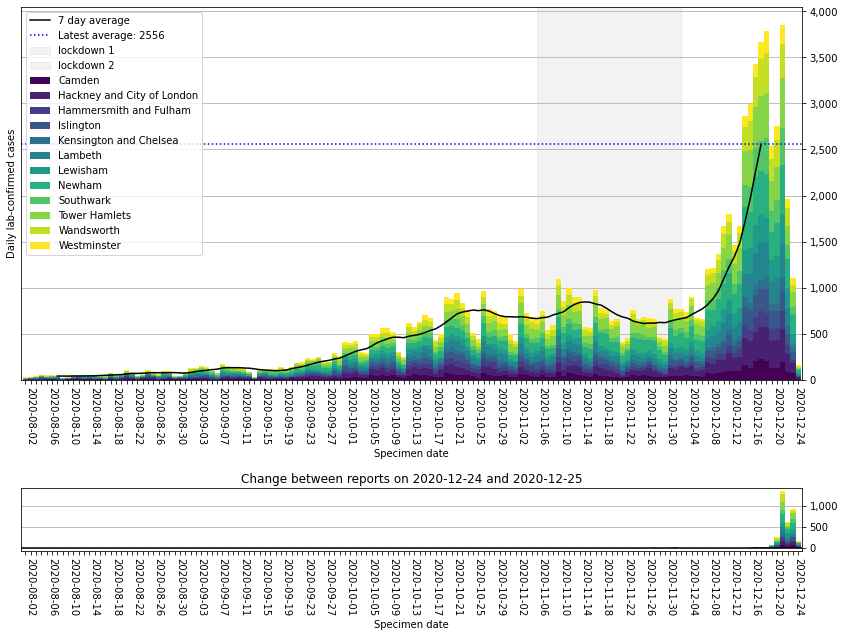

In [22]:
plot_areas(for_date, areas=london_areas, uncertain_days=6, earliest=second_wave)

In [33]:
top_10_types = ltla
data = recent_phe_data_summed(for_date, by=top_10_types)

In [34]:
top_10 = data.sort_values(per100k, ascending=False)[:10][[area,per100k,cases,specimen_date]]
top_10

,Area name,"cases per 100,000 people",Daily lab-confirmed cases,Specimen date
Area code,,,,
E07000068,Brentwood,1199.672817,924.0,2020-12-24
E07000072,Epping Forest,1026.661300,1352.0,2020-12-24
E06000034,Thurrock,997.470475,1739.0,2020-12-24
E07000069,Castle Point,928.343808,839.0,2020-12-24
E09000016,Havering,883.445321,2293.0,2020-12-24
E07000095,Broxbourne,839.852383,817.0,2020-12-24
E07000066,Basildon,831.201021,1556.0,2020-12-24
E07000075,Rochford,786.329091,687.0,2020-12-24
E09000004,Bexley,783.367635,1945.0,2020-12-24


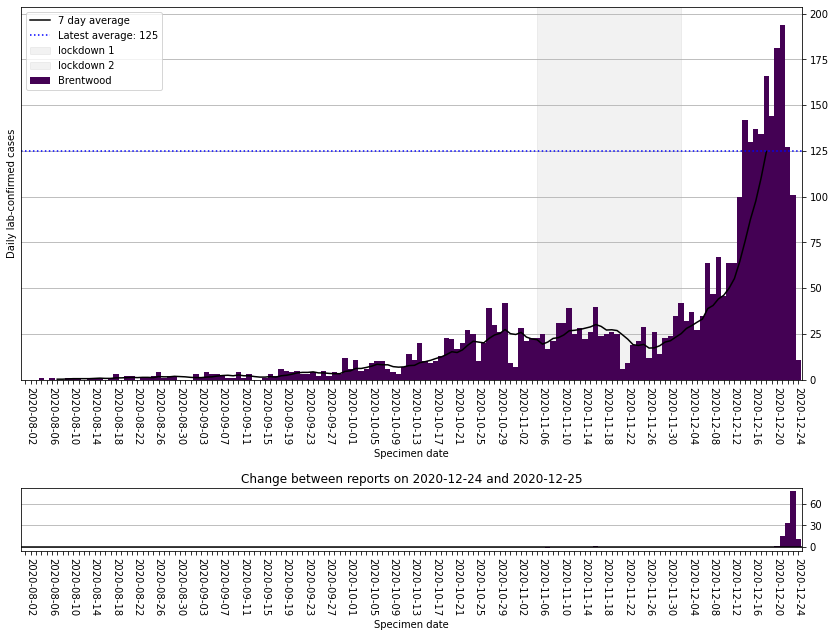

In [35]:
plot_areas(for_date, areas = [top_10.iloc[0].name], area_types=top_10_types, uncertain_days=5, earliest=second_wave)

In [36]:
top_10 = data.sort_values(cases, ascending=False)[:10][[area,per100k,cases,specimen_date]]
top_10

,Area name,"cases per 100,000 people",Daily lab-confirmed cases,Specimen date
Area code,,,,
E08000025,Birmingham,247.588053,2827.0,2020-12-24
E09000010,Enfield,716.010474,2390.0,2020-12-24
E09000026,Redbridge,774.845850,2365.0,2020-12-24
E09000016,Havering,883.445321,2293.0,2020-12-24
E09000025,Newham,626.107936,2211.0,2020-12-24
E09000030,Tower Hamlets,642.350152,2086.0,2020-12-24
E06000035,Medway,721.937420,2011.0,2020-12-24
E09000003,Barnet,498.144588,1972.0,2020-12-24
E09000004,Bexley,783.367635,1945.0,2020-12-24


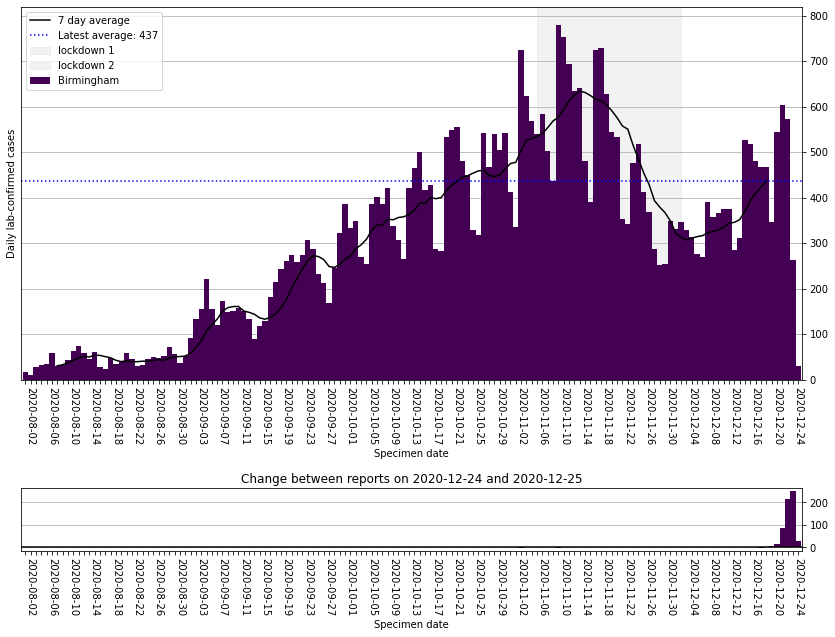

In [37]:
plot_areas(for_date, areas = [top_10.iloc[0].name], area_types=top_10_types, uncertain_days=5, earliest=second_wave)

In [5]:
zoe_date, zoe_df = zoe_map_data()

In [6]:
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)

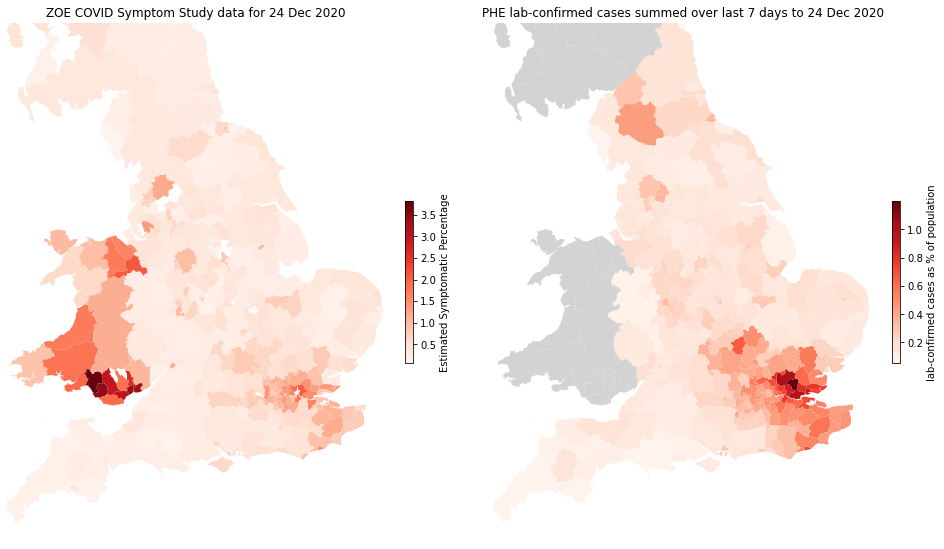

In [7]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [30]:
zoe_new_lad16 = add_simple_geoms(zoe_df)

In [31]:
bokeh_zoe_vs_phe_map(zoe_new_lad16, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

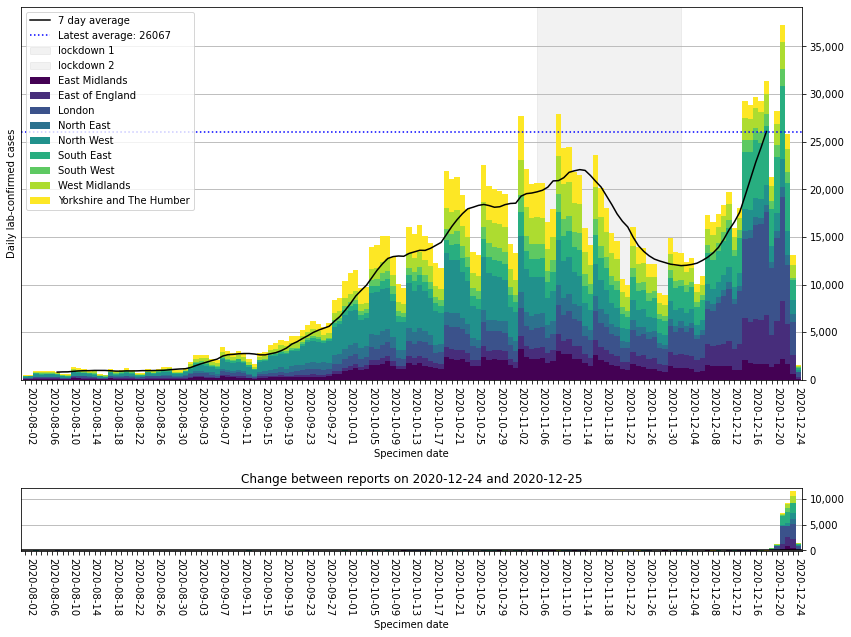

In [32]:
from functools import partial
from phe import plot_with_diff, data_for_date
plot_with_diff(
    for_date-timedelta(days=0),
    partial(data_for_date, area_types=region),
    uncertain_days=5, 
    diff_days=1,
    diff_log_scale=False,
    diff_ylims=[-10, 12_000],
    earliest=second_wave
)